# Uncovering Funding Trends in Private Capital


Our goal is to significantly reduce the problem space, from several hundred thousand companies and funding rounds, to a manageable cluster of companies, thereby allowing VC investors to focus their efforts on those particular companies, or other companies in early stage funding that are approximately similar.

We are provided with two datasets - one consisting of company descriptions and metadata, and another consisting of funding round data. In real-world, we may want to explore certain features such as `employee_count`, geographic location, i.e. `country_code` and `city`, as well as the number of investors and investor names. However, for the purpose of this exercise, we ignore these features, and focus only on amount raised over time, and textual descriptions of the companies.

Our approach is as follows:

* We perform exploratory data analysis (EDA), where we both manually (a.k.a. the "eyeball" method) and in Pandas, examine the data
* We reduce the number of funded companies by focusing on (1) companies that have had their funding rounds in the last year, i.e. 2019 in the dataset; (2) companies with only a few funding rounds; and (3) companies with the most positive funding trends
* We use a Bayesian topic modelling method (Latent Dirichlet Allocation - LDA - with Gibbs sampling) to uncover latent clusters of companies with common "themes", such as "legal", "insurance", "healthcare", "blockchain", etc.
* We use the trained LDA model from the previous step to assign these topics/themes to the reduced set of companies
* Finally, we suggest the trending industries with the largest number of LDA topic assignments, and show some examples of similar companies with early seed funding

In [297]:
from multiprocessing import cpu_count
from operator import itemgetter
from pathlib import Path
import re
from typing import List, Optional, Tuple

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Part 1 - Data Loading and Exploration

In [175]:
funding_path = "./data/funding.json"

funding = pd.read_json(funding_path, lines=True)

funding.head(n=10)

,funding_round_uuid,company_uuid,company_name,investment_type,announced_on,raised_amount_usd,investor_names,investor_count
0,2ace3f55-5a66-484c-ce06-3a326f8eaafd,6faee0d4-a0d2-3404-f9a3-441ca46fccf0,CryptoPing,initial_coin_offering,2017-07-07,2600000.0,{},NaN
1,36380646-783c-0618-d61e-d9708c4c9366,d319be0c-1b6a-a685-ef1e-ac79d04605ce,WaterO,product_crowdfunding,2016-04-01,85669.0,{},NaN
2,4b52d69d-c681-44e1-ba88-1113df10dfa5,565777f7-c91e-47f8-8027-6b3617e3d7bf,LoopX,initial_coin_offering,2018-02-12,4500000.0,{},NaN
3,4bc097d2-671f-45a3-890a-ca32980f939a,90ef7195-1681-45c2-870d-c47647240f29,Lancer Network,initial_coin_offering,2018-05-26,NaN,{},NaN
4,590a9864-9a4d-4c8f-81c1-5aa443f14af3,85c58328-3b67-4b92-ba6e-167ba1d2072f,Fullframe Design,product_crowdfunding,2019-09-20,422293.0,{},NaN
5,5964ded2-d171-4010-bcf5-804d23519cf0,951817b8-4175-40d3-993f-3d514c31b089,Exsulcoin,initial_coin_offering,2018-02-18,NaN,{},NaN
6,60f4b374-ca98-426f-bfcb-176442a6df91,3e87bd2b-fe68-53b7-3f02-45a18e69a072,The Women's Shave Club,product_crowdfunding,2019-03-24,NaN,{},NaN
7,6c43514f-4816-45eb-8cc0-e97654a8d889,8fab0172-52d2-42d9-9fa6-14ca2963ad94,LoanBit,initial_coin_offering,2018-04-02,NaN,{},NaN
8,6e53ac26-d749-48a2-9b30-bd1ce70373c0,94aa64dd-2405-40fa-a0d2-c1796e365817,Spicy Tails,product_crowdfunding,2019-01-21,282426.0,{},NaN
9,8587d080-c33b-4270-8807-15b59a1002ea,5ba526c9-b702-441a-8794-02510fc84e55,Stealth,initial_coin_offering,2019-01-12,NaN,{},NaN


In [176]:
funding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284307 entries, 0 to 284306
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   funding_round_uuid  284307 non-null  object 
 1   company_uuid        284307 non-null  object 
 2   company_name        284307 non-null  object 
 3   investment_type     284307 non-null  object 
 4   announced_on        284307 non-null  object 
 5   raised_amount_usd   207515 non-null  float64
 6   investor_names      284307 non-null  object 
 7   investor_count      203436 non-null  float64
dtypes: float64(2), object(6)
memory usage: 17.4+ MB


In [177]:
# let's ignore investor info and focus only on where the funds were raised

del funding["investor_count"]
del funding["investor_names"]

funding.dropna(inplace=True)  # removing funding rounds with NaN amounts

funding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207515 entries, 0 to 284306
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   funding_round_uuid  207515 non-null  object 
 1   company_uuid        207515 non-null  object 
 2   company_name        207515 non-null  object 
 3   investment_type     207515 non-null  object 
 4   announced_on        207515 non-null  object 
 5   raised_amount_usd   207515 non-null  float64
dtypes: float64(1), object(5)
memory usage: 11.1+ MB


In [178]:
# convert `announced_on` to `datetime` format so we can do queries later

funding.announced_on = pd.to_datetime(funding.announced_on)

funding.announced_on.dtype

dtype('<M8[ns]')

In [179]:
# let's check how many and what kind of different funding rounds occurred

funding.investment_type.nunique()

28

In [180]:
funding.investment_type.unique()

array(['initial_coin_offering', 'product_crowdfunding', 'post_ipo_debt',
       'secondary_market', 'series_f', 'post_ipo_secondary', 'series_h',
       'series_g', 'series_i', 'series_j', 'seed', 'angel', 'grant',
       'pre_seed', 'series_a', 'series_b', 'series_c', 'series_d',
       'series_e', 'undisclosed', 'debt_financing', 'private_equity',
       'series_unknown', 'corporate_round', 'post_ipo_equity',
       'convertible_note', 'equity_crowdfunding', 'non_equity_assistance'],
      dtype=object)

In [234]:
# examine how much of each funding rounds there are in the dataset

funding.groupby("investment_type")["investment_type"].count().sort_values(ascending=False)

investment_type
seed                     57913
series_unknown           36341
series_a                 27071
series_b                 15745
grant                    13448
debt_financing           10492
angel                     9349
series_c                  7724
convertible_note          4269
pre_seed                  4024
post_ipo_equity           3506
series_d                  3380
private_equity            3121
equity_crowdfunding       3056
undisclosed               2373
series_e                  1409
product_crowdfunding       831
post_ipo_debt              825
corporate_round            638
non_equity_assistance      552
series_f                   509
initial_coin_offering      482
secondary_market           188
series_g                   164
series_h                    62
post_ipo_secondary          24
series_i                    10
series_j                     9
Name: investment_type, dtype: int64

In [182]:
# let's see where first and last funding rounds took place

print(f"First funding round: {funding.announced_on.min()}")
print(f"Last funding round: {funding.announced_on.max()}")

First funding round: 1915-07-15 00:00:00
Last funding round: 2019-10-08 00:00:00


In [183]:
# let's group rounds by year - we'd like to get a better picture
# of year-by-year rounds, and how far back they go

funding["announced_on_year"] = funding.announced_on.dt.year

funding.groupby("announced_on_year").size().sort_values(ascending=False)

announced_on_year
2018    25015
2017    22983
2015    22435
2016    22145
2014    20399
2013    16032
2019    14898
2012    12221
2011     9919
2010     8448
2009     6382
2008     4732
2007     4480
2000     3395
2006     3307
2005     2625
2004     1978
2003     1621
2001     1551
2002     1508
1999      934
1998      204
1997      110
1996       70
1995       32
1994       26
1992       11
1993        8
1982        8
1991        5
1990        5
1985        4
1983        4
1984        4
1987        4
1989        2
1981        2
1988        1
1980        1
1979        1
1977        1
1970        1
1968        1
1919        1
1915        1
dtype: int64

## Part 2 - Data Filtering and Trend Estimation

In [187]:
# let's focus on the companies that have their last funding rounds in 2019
# and have had 2-3 funding rounds - we don't want overly established companies since we
# probably missed that train!

companies_filtered = frozenset(funding.query("announced_on_year == 2019")["company_uuid"])

In [188]:
len(companies_filtered)

13808

In [268]:
companies_filtered_uuids = set()

for row in funding.groupby("company_uuid").size().reset_index(name="investment_count").query(
    "(investment_count >= 2) and (investment_count <= 3)").itertuples():
    if row.company_uuid in companies_filtered:
        companies_filtered_uuids.add(row.company_uuid)

In [269]:
len(companies_filtered_uuids)

4544

In [270]:
funding_filtered = funding.loc[funding.company_uuid.isin(companies_filtered_uuids)]

len(funding_filtered)

10724

In [271]:
# add a column with standardized amounts to make maths more sensible
# for trend estimation

funding_filtered["raised_amount_usd_sd"] = StandardScaler().fit_transform(funding_filtered[["raised_amount_usd"]])

funding_filtered.head(n=3)

/Users/armin.catovic@schibsted.com/.pyenv/versions/3.6.14/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,funding_round_uuid,company_uuid,company_name,investment_type,announced_on,raised_amount_usd,announced_on_year,raised_amount_usd_sd
169,b968e118-c515-45c6-b5ce-2f39f1a4eb7b,00dcf3e7-d691-70b1-fa88-3d146d02aa1f,Helix BioPharma,post_ipo_debt,2019-08-21,5267593.0,2019,-0.121340
211,c66e3e81-e4d6-424a-a653-1c4b38008e0a,12367b55-7b07-4ca6-a902-258d5ff6bac8,Algorand,initial_coin_offering,2019-06-19,60000000.0,2019,0.446654
236,0617ed5c-007c-4ba5-a238-ae800888cb10,442ecc46-11ef-c545-0934-19d502be72bd,Bank of Ireland,post_ipo_debt,2019-10-07,329812402.0,2019,3.246672


In [334]:
# go through all the filtered companies and estimate their funding trend
# construct a new df

company_trends = []

for company_uuid in companies_filtered_uuids:
    tmp_df = funding_filtered.query(f"company_uuid == '{company_uuid}'").sort_values("announced_on")
    tot_raised_amount_usd = tmp_df.raised_amount_usd.sum()
    trend = np.polyfit(list(range(len(tmp_df))), tmp_df.raised_amount_usd_sd, deg=1)
    company_trends.append({
        "company_uuid": company_uuid,
        "company_name": tmp_df.company_name.iloc[0],
        "tot_raised_amount_usd": tot_raised_amount_usd,
        "funding_trend": trend[0],
    })

company_trends = pd.DataFrame(company_trends)

In [335]:
len(company_trends)

4544

In [336]:
# retain companies with only a clear positive funding trend

company_trends = company_trends.query("funding_trend > 0.5")

len(company_trends)

142

In [337]:
# look at the top-50 companies

company_trends.sort_values("funding_trend", ascending=False).head(n=50)

,company_uuid,company_name,tot_raised_amount_usd,funding_trend
4457,44e89f00-dd04-e003-18a4-cba5f10c4f72,Argo AI,3.600000e+09,16.604239
1654,315e1e59-3784-ab73-9c4a-447d2616ae82,SAP,1.301371e+09,13.476714
3634,cf2c678c-b81a-80c3-10d1-9c5e76448e51,OpenAI,1.000120e+09,10.376404
2826,d70afb2d-d4cf-d372-05eb-c3152fceff87,Genex Power,6.262000e+08,6.162248
3469,c3730a4b-95de-4220-a2cf-c224ae3af6d3,Greensill Capital,1.050000e+09,5.707707
3128,b3271f1e-23a6-ce3c-6618-fc50b5021622,Lenta,9.540000e+08,5.230335
2187,3df5834f-9cbb-f5c3-d785-2bf86cc9541d,Jack in the Box,2.100000e+09,5.188825
31,c0e46886-79a3-afa6-5b73-4c9f910c646e,Nuro,1.032149e+09,4.876723
2528,365ff3e1-436f-8ed9-e0e4-9de1eead3d9b,Emirates National Oil Company,9.200000e+08,4.773719
1419,2246da71-cc8c-4774-8059-331c39343ee4,Kaseya,5.447773e+08,4.724141


In [339]:
company_trends.sort_values("funding_trend", ascending=False).tail(n=10)

,company_uuid,company_name,tot_raised_amount_usd,funding_trend
2442,7e0ac242-b9c7-9224-de57-99cc94362b7a,PQ Bypass,70036594.0,0.518503
505,51d826e1-5a80-ba98-61e1-acaeea4cd108,Sol Global investments,50170228.0,0.517116
700,2c9a3c45-ad11-40b6-9e96-31bd0d380fcd,Pharvaris,82287334.0,0.515901
1130,2e6cec9d-6ba6-4e46-8a0f-2b2dc3ae8d6b,Inari,129000000.0,0.508505
2703,7395521a-5d2d-cce0-bfa3-4da470f1940a,EpimAb Biotherapeutics,99000000.0,0.508505
160,e355cd16-7636-3dbf-e7b9-419e8702ed00,Capify,145888176.0,0.507058
648,ec65f75c-f20f-4d42-8ecf-c745c5849ab2,Life House,110400000.0,0.506948
945,f99c5e3c-496a-420f-9a77-5711dd500091,Manulife US REIT,236700000.0,0.505392
802,7ad9a103-f900-4ae9-9d72-252a60e79f9f,Kkguan,70625847.0,0.504622
3070,4f5fa8bd-8653-cce5-58e6-ac686ed761b4,Horizon Technology Finance,130900000.0,0.503316


## Part 3 - Estimating Latent Topics/Themes Based on Company Data

In [3]:
org_path = "./data/org.json"

org = pd.read_json(org_path, lines=True)

org.head(n=10)

,uuid,company_name,homepage_url,country_code,city,founded_on,short_description,description,funding_rounds,funding_total_usd,employee_count,last_funding_on
0,51d72ce7-3075-b4d9-941f-8a90b23c9c14,BN Media,http://bnmediallc.com,,,2010-01-01,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,0,,11-50,NaN
1,62a90659-df0d-0ff8-c30e-b393bdbbb490,BSN Glasspack,http://www.bsnglasspack.com/,,,2000-01-01,The second-largest glass container maker in Eu...,NaN,0,,unknown,NaN
2,01d93fe1-2f07-440b-870b-77aee8f51910,Connected Auto,http://www.connectedauto.org/,,,NaN,Connected Auto provide synergy and communicati...,Connected Auto provide synergy and communicati...,0,,unknown,NaN
3,5dd0356b-03f9-47f8-9cf5-e10189c400af,DCG Group,,,,NaN,DCG Group,NaN,0,,unknown,NaN
4,c10d479d-5142-549e-8d09-4e9ff37a170b,FactorPrism,http://www.factorprism.com,,,NaN,Makers of revolutionary Smart Data Discovery s...,NaN,0,,unknown,NaN
5,fd8e506a-5190-df18-1e56-fd7ca05af161,FastGrowth Company,http://fastgrowthco.com/,,,2016-04-01,On Demand Sales Consulting and Services Company,NaN,0,,1-10,NaN
6,806486a6-7864-892b-8277-16fd8fd63205,Garden Connections,http://gardenconnections.com,,,NaN,Garden Connections transforms people's lives b...,NaN,0,,1-10,NaN
7,f066b1aa-054a-398b-6797-e6bca7f777a1,Kukers,http://www.kukers.com,,,NaN,"Discover, organize and share recipes",Kukers.com is a community where you can organi...,0,,1-10,NaN
8,2c72d454-0444-4498-9294-53156181d0f3,Maher Commercial Realty,,,,NaN,Commercial real estate group founded by Oron M...,NaN,0,,unknown,NaN
9,b0014b72-e66c-4dd1-8639-d19bf5ba3aa1,McKonly & Asbury,http://macpas.com,,,NaN,McKonly & Asbury is a certified public account...,NaN,0,,101-250,NaN


In [4]:
org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803824 entries, 0 to 803823
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uuid               803824 non-null  object
 1   company_name       803824 non-null  object
 2   homepage_url       803824 non-null  object
 3   country_code       803824 non-null  object
 4   city               803824 non-null  object
 5   founded_on         571765 non-null  object
 6   short_description  803824 non-null  object
 7   description        572219 non-null  object
 8   funding_rounds     803824 non-null  int64 
 9   funding_total_usd  803824 non-null  object
 10  employee_count     803824 non-null  object
 11  last_funding_on    153494 non-null  object
dtypes: int64(1), object(11)
memory usage: 73.6+ MB


In [311]:
org.description.fillna("", inplace=True)

org.head(n=5)

,uuid,company_name,homepage_url,country_code,city,founded_on,short_description,description,funding_rounds,funding_total_usd,employee_count,last_funding_on
0,51d72ce7-3075-b4d9-941f-8a90b23c9c14,BN Media,http://bnmediallc.com,,,2010-01-01,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,0,,11-50,NaN
1,62a90659-df0d-0ff8-c30e-b393bdbbb490,BSN Glasspack,http://www.bsnglasspack.com/,,,2000-01-01,The second-largest glass container maker in Eu...,,0,,unknown,NaN
2,01d93fe1-2f07-440b-870b-77aee8f51910,Connected Auto,http://www.connectedauto.org/,,,NaN,Connected Auto provide synergy and communicati...,Connected Auto provide synergy and communicati...,0,,unknown,NaN
3,5dd0356b-03f9-47f8-9cf5-e10189c400af,DCG Group,,,,NaN,DCG Group,,0,,unknown,NaN
4,c10d479d-5142-549e-8d09-4e9ff37a170b,FactorPrism,http://www.factorprism.com,,,NaN,Makers of revolutionary Smart Data Discovery s...,,0,,unknown,NaN


In [6]:
def normalize_text(s: str) -> str:
    return s.lower()

s = "The second-largest glass container maker in Europe"

print(normalize_text(s))

the second-largest glass container maker in europe


In [107]:
# we want to capture both English and Nordic words;
# we only consider words of >= 2 characters, and letters only
token_pattern = re.compile(r'[A-ZÅÄÖÆØa-zåäöæø][A-ZÅÄÖÆØa-zåäöæø]+')

def tokenize(s: str) -> List[str]:
    return token_pattern.findall(s)

s = """InnovActionLab is a non-profit organization that 
conducts seminars and trial pitches to enable the growth of entrepreneurs"""

print(tokenize(s))

['InnovActionLab', 'is', 'non', 'profit', 'organization', 'that', 'conducts', 'seminars', 'and', 'trial', 'pitches', 'to', 'enable', 'the', 'growth', 'of', 'entrepreneurs']


In [108]:
s = org.iloc[0].short_description + org.iloc[0].description
print(f"Original: {s}")
print(f"Normalized: {normalize_text(s)}")
print(f"Normalized+Tokenized: {tokenize(normalize_text(s))}")
print(f"Normalized+Tokenized+Filtered: {[word for word in tokenize(normalize_text(s)) if word not in STOPWORDS]}")

Original: BN Media is an entity that features three cross promoted faith and inspiration brands including Affinity4, Beliefnet, and Cross Bridge.The mission of BN Media is to serve the vast online market for spirituality and inspiration, bringing audio-visual and written content to the masses while helping people make a difference for their favorite nonprofit organization. BN Media achieves this by bridging the gap through which ordinary activities inspire activism, online giving, and volunteerism.
Normalized: bn media is an entity that features three cross promoted faith and inspiration brands including affinity4, beliefnet, and cross bridge.the mission of bn media is to serve the vast online market for spirituality and inspiration, bringing audio-visual and written content to the masses while helping people make a difference for their favorite nonprofit organization. bn media achieves this by bridging the gap through which ordinary activities inspire activism, online giving, and volu

In [109]:
# let's first build a dictionary using both short and long company descriptions
# we concatanate short and long descriptions

min_doc_len = 10  # at least 10 words in the company description

dictionary = Dictionary()

for row in org.itertuples():
    s = row.short_description + row.description
    s = normalize_text(s)
    doc = [word for word in tokenize(s) if word not in STOPWORDS]
    if len(doc) >= min_doc_len:
        dictionary.add_documents([doc])

In [110]:
len(dictionary)

677823

In [111]:
dictionary.doc2bow(["cryptocurrency"])

[(2674, 1)]

In [112]:
def get_min_count_threshold(num_docs: int) -> int:
  """Use power law based method of finding minimum number of word counts."""
  return np.ceil(2 * (0.02 * num_docs) ** (1.0 / np.log(10)))

print(get_min_count_threshold(len(org)))

135.0


In [113]:
# prune the dictionary to make it more manageable
# and get rid off rare words

min_df = get_min_count_threshold(len(org))
max_df = 0.9
keep_n = 10_000  # let's cap the dictionary to max `keep_n` words

dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=keep_n)

In [114]:
len(dictionary)

10000

In [115]:
# build a corpus that will be used for topic modelling

min_doc_len = 10  # at least 10 "dictionary "words in the company description

corpus = []

for row in org.itertuples():
    s = row.short_description + row.description
    s = normalize_text(s)
    doc = tokenize(s)
    bow = dictionary.doc2bow(doc)
    if len(bow) >= min_doc_len:
        corpus.append(bow)

In [116]:
len(corpus)

573384

In [117]:
# build a LDA topic model using Gibbs sampling/MALLET
# NOTE: Here we manually select T=100 topics, but in "real world",
# we would want to iterate through a range of T values, and select
# one based on a coherence metric, and some additional topic 
# evaluations, such as topic overlap and topic uniqueness;
# also it would be a good idea to do human evaluations e.g. with
# analysts/partners, to sanity-check the topics

path_to_mallet_bin = "~/Mallet-202108/bin/mallet"

num_workers = cpu_count()
num_topics = 100
optimize_interval = 100
iterations = 800
random_seed = 42

model = LdaMallet(
    path_to_mallet_bin, 
    corpus=corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    workers=num_workers,
    iterations=iterations,
    optimize_interval=optimize_interval,
    random_seed=random_seed
)

In [249]:
model.print_topics(num_topics=20, num_words=10)

[(9,
  '0.057*"la" + 0.056*"los" + 0.048*"en" + 0.046*"angeles" + 0.022*"el" + 0.019*"le" + 0.019*"es" + 0.018*"las" + 0.017*"des" + 0.016*"para"'),
 (18,
  '0.209*"insurance" + 0.032*"life" + 0.026*"benefits" + 0.021*"risk" + 0.018*"employee" + 0.017*"claims" + 0.017*"plans" + 0.016*"health" + 0.016*"agency" + 0.015*"services"'),
 (36,
  '0.085*"law" + 0.082*"legal" + 0.035*"firm" + 0.024*"tax" + 0.018*"lawyers" + 0.018*"clients" + 0.017*"property" + 0.017*"intellectual" + 0.016*"firms" + 0.013*"case"'),
 (22,
  '0.025*"eye" + 0.022*"glass" + 0.016*"ab" + 0.016*"doors" + 0.016*"window" + 0.016*"wood" + 0.015*"door" + 0.015*"sweden" + 0.014*"roofing" + 0.014*"windows"'),
 (74,
  '0.024*"clinical" + 0.024*"drug" + 0.022*"pharmaceutical" + 0.022*"cancer" + 0.019*"treatment" + 0.018*"company" + 0.017*"diseases" + 0.016*"development" + 0.014*"therapeutics" + 0.014*"disease"'),
 (62,
  '0.053*"oil" + 0.049*"gas" + 0.041*"company" + 0.040*"canada" + 0.031*"exploration" + 0.030*"gold" + 0.024

In [119]:
def bow2doc(bow: List[Tuple[int, int]], dictionary: Dictionary) -> List[str]:
    doc = []
    for token_id, cnt in bow:
        doc.extend([dictionary.id2token[token_id]] * cnt)
    return doc

In [120]:
bow2doc(corpus[0], dictionary)

['achieves',
 'activities',
 'affinity',
 'audio',
 'bn',
 'bn',
 'bn',
 'brands',
 'bridge',
 'bridging',
 'bringing',
 'content',
 'cross',
 'cross',
 'difference',
 'entity',
 'faith',
 'favorite',
 'features',
 'gap',
 'giving',
 'helping',
 'including',
 'inspiration',
 'inspiration',
 'inspire',
 'market',
 'masses',
 'media',
 'media',
 'media',
 'mission',
 'nonprofit',
 'online',
 'online',
 'ordinary',
 'organization',
 'people',
 'promoted',
 'serve',
 'vast',
 'visual',
 'written']

In [141]:
# construct a test set for estimating NPMI coherence metrics

test_docs_len = 50_000
test_docs_ixs = np.random.randint(0, len(corpus), test_docs_len)
test_docs = [bow2doc(corpus[ix], dictionary) for ix in test_docs_ixs]

In [142]:
len(test_docs)

50000

In [143]:
test_docs[0]

['businesses',
 'cutting',
 'edge',
 'platform',
 'platform',
 'natural',
 'smart',
 'smart',
 'ai',
 'ai',
 'ai',
 'ai',
 'learning',
 'data',
 'excellent',
 'development',
 'ensuring',
 'hr',
 'hr',
 'hr',
 'dedicated',
 'dedicated',
 'language',
 'box',
 'points',
 'companion',
 'companion',
 'employees',
 'employees',
 'processing',
 'self',
 'powered',
 'powered',
 'powered',
 'assistant',
 'capabilities',
 'capabilities',
 'backed',
 'virtual',
 'engaging',
 'engaging',
 'cognitive',
 'leverages',
 'chatbot',
 'conversational',
 'mn']

In [144]:
cm = CoherenceModel(
    model=model, 
    texts=test_docs, 
    dictionary=dictionary, 
    window_size=10,
    coherence="c_v",
    topn=10,
    processes=cpu_count()
)

In [145]:
coherence = cm.get_coherence()

print(coherence)

0.35541689641778573


In [126]:
# convert MALLET model to VBA LdaModel so we can use inference functionality

model = malletmodel2ldamodel(model, iterations=200)

In [146]:
model[corpus[1]]

[(1, 0.09996683078144034),
 (8, 0.06365521859418705),
 (26, 0.049369299656384175),
 (28, 0.13570786458687772),
 (60, 0.09622979754786617),
 (68, 0.06964617203199433),
 (71, 0.17540771928037932),
 (81, 0.06609531382029407)]

In [147]:
bow2doc(corpus[1], dictionary)

['academia',
 'academia',
 'auto',
 'auto',
 'automobile',
 'automobile',
 'autonomous',
 'communications',
 'communications',
 'companies',
 'companies',
 'connected',
 'connected',
 'connected',
 'industry',
 'institutions',
 'institutions',
 'manufacturers',
 'manufacturers',
 'provide',
 'provide',
 'public',
 'public',
 'synergy',
 'synergy',
 'technology',
 'technology',
 'vehicle']

In [148]:
model.print_topic(71)

'0.059*"public" + 0.037*"national" + 0.037*"government" + 0.025*"private" + 0.024*"association" + 0.023*"organization" + 0.022*"members" + 0.017*"international" + 0.015*"sector" + 0.015*"profit"'

In [149]:
model.inference([corpus[1]])

(array([[0.0722175 , 4.3839064 , 0.15412972, 0.09138311, 0.12494364,
         0.1789937 , 0.17162383, 0.07228729, 0.07778904, 0.02954013,
         0.07742597, 0.08995983, 0.18297044, 0.09525282, 0.12850749,
         0.17801879, 0.19831053, 0.10025477, 0.03994105, 0.08441901,
         0.0877855 , 0.05217113, 0.04663398, 0.07898486, 0.14446794,
         0.13667435, 1.75172526, 0.05145809, 5.55398071, 0.1158852 ,
         0.15523873, 0.12856912, 0.10751826, 0.12808869, 0.16515132,
         0.10093489, 0.04087644, 0.10294653, 0.05690698, 0.05248793,
         0.08761441, 0.05702565, 0.06873363, 0.05956162, 0.08029735,
         0.07803922, 0.09802842, 0.06410416, 0.07112349, 0.05420702,
         0.05908284, 0.14064722, 0.05180585, 0.16430211, 0.14966459,
         0.04880849, 0.07756137, 0.17556097, 0.08731612, 0.09743832,
         5.27523964, 0.0613945 , 0.04860828, 0.06020678, 0.06082487,
         0.15709731, 0.11915213, 0.18059678, 2.59392962, 0.07668416,
         0.1078305 , 6.6633304 , 0

In [150]:
# construct a test corpus for visualizing topic clusters

test_corpus_len = 50_000
test_corpus_ixs = np.random.randint(0, len(corpus), test_corpus_len)
test_corpus = [corpus[ix] for ix in test_corpus_ixs]

In [151]:
len(test_corpus)

50000

In [153]:
X = model.inference(test_corpus)[0]  # ignore sstats

print(X.shape)

(50000, 100)


In [154]:
X_tsne = TSNE(n_components=2, random_state=random_seed).fit_transform(X)

print(X_tsne.shape)

(50000, 2)


In [159]:
y = X.argmax(axis=1)  # topic assignments for each company description, based on highest probability (very naive!)

print(y.shape)

(50000,)


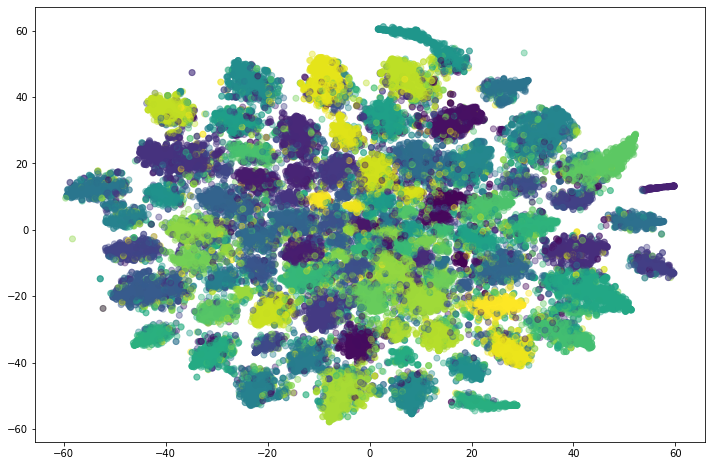

In [233]:
# let's look at some of these clusters!

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, alpha=0.4)
plt.show()

In [170]:
# save model for future use

model_path = Path("./model/")
model_path.mkdir(parents=True, exist_ok=True)
model_path = model_path / "model"
model.save(str(model_path))

In [171]:
# load model

#model = LdaModel.load(str(model_path))

## Part 4 - Assigning Topics to Companies with Positive Trends

In [287]:
def get_topic_label(topic_id: int, model: LdaModel) -> str:
    """We label the topic by simply concatenating top-3 terms."""
    return "-".join([word for word, _, in model.show_topic(topic_id)[:3]])

In [290]:
get_topic_label(4, model)

'community-people-social'

In [342]:
def get_topic_assignment(
    bow: List[Tuple[int, int]], 
    model: LdaModel, 
    min_prob: float = 0.1) -> Optional[Tuple[int, str]]:
    """Pick the most probably topic, or None; return tuple(topic_id, topic_label)"""
    topic_assignments = model.get_document_topics(bow, minimum_probability=min_prob)
    if not topic_assignments:
        return (None, None)
    
    topic_id = max(topic_assignments, key=itemgetter(1))[0]
    topic_label = get_topic_label(topic_id, model)
    
    return (topic_id, topic_label)

In [326]:
get_topic_assignment(dictionary.doc2bow(tokenize(normalize_text(org.iloc[0].description))), model)

(4, 'community-people-social')

In [302]:
company_trends["topic_id"] = None
company_trends["topic_label"] = None

company_trends.head()

,company_uuid,company_name,tot_raised_amount_usd,funding_trend,topic_id,topic_label
31,c0e46886-79a3-afa6-5b73-4c9f910c646e,Nuro,1.032149e+09,4.876723,None,None
32,7196d20b-9360-455b-a592-885224468d02,Zhangshang Tangyi,1.158000e+08,0.873798,None,None
35,ce2c7108-eb69-4c76-85be-a65dd115d4c9,Zhangmen,4.990461e+08,1.665374,None,None
55,73c8f0b9-3735-44fd-8463-a94bd86f2e03,AdaptHealth,6.020000e+08,2.194873,None,None
56,0ffa51f0-70cf-4d6e-83a5-db1a66b9f59c,WISECO Technology,1.087973e+08,0.824705,None,None


In [343]:
company_topic_assignments = []

for row in company_trends.itertuples():
    s = ""
    short_desc = org.short_description[org.uuid == row.company_uuid].to_list()
    if short_desc:
        s += short_desc[0]
    long_desc = org.description[org.uuid == row.company_uuid].to_list()
    if long_desc:
        s += long_desc[0]
    if not s:
        topic_id, topic_label = (None, None)
    else:
        bow = dictionary.doc2bow(tokenize(normalize_text(s)))
        topic_id, topic_label = get_topic_assignment(bow, model)
    company_topic_assignments.append({
        "company_uuid": row.company_uuid,
        "topic_id": topic_id,
        "topic_label": topic_label,
    })
    #print(f"company_name: {row.company_name}, topic_id: {topic_id}, topic_label: {topic_label}")

company_topic_assignments = pd.DataFrame(company_topic_assignments)

In [344]:
company_topic_assignments.head()

,company_uuid,topic_id,topic_label
0,c0e46886-79a3-afa6-5b73-4c9f910c646e,92,create-world-ideas
1,7196d20b-9360-455b-a592-885224468d02,45,health-care-medical
2,ce2c7108-eb69-4c76-85be-a65dd115d4c9,89,training-education-learning
3,73c8f0b9-3735-44fd-8463-a94bd86f2e03,45,health-care-medical
4,0ffa51f0-70cf-4d6e-83a5-db1a66b9f59c,77,services-company-provider


In [348]:
company_trends = company_trends.merge(company_topic_assignments[["company_uuid","topic_id", "topic_label"]])

In [349]:
company_trends.head()

,company_uuid,company_name,tot_raised_amount_usd,funding_trend,topic_id,topic_label
0,c0e46886-79a3-afa6-5b73-4c9f910c646e,Nuro,1.032149e+09,4.876723,92,create-world-ideas
1,7196d20b-9360-455b-a592-885224468d02,Zhangshang Tangyi,1.158000e+08,0.873798,45,health-care-medical
2,ce2c7108-eb69-4c76-85be-a65dd115d4c9,Zhangmen,4.990461e+08,1.665374,89,training-education-learning
3,73c8f0b9-3735-44fd-8463-a94bd86f2e03,AdaptHealth,6.020000e+08,2.194873,45,health-care-medical
4,0ffa51f0-70cf-4d6e-83a5-db1a66b9f59c,WISECO Technology,1.087973e+08,0.824705,77,services-company-provider


In [351]:
# let's list the top-10 industries where the funding is trending

company_trends.groupby("topic_label").size().sort_values(ascending=False).head(n=10)

topic_label
clinical-drug-pharmaceutical    19
travel-car-vehicle               9
real-estate-property             7
china-chinese-singapore          7
ai-intelligence-machine          5
health-care-medical              5
energy-power-solar               5
financial-bank-banking           4
capital-companies-venture        4
platform-online-users            4
dtype: int64

In [354]:
# let's look at some trending "pharma" companies

company_trends[company_trends.topic_label == "clinical-drug-pharmaceutical"].sort_values("funding_trend", ascending=False).head(n=10)

,company_uuid,company_name,tot_raised_amount_usd,funding_trend,topic_id,topic_label
35,77e35b07-44c5-cc5d-380e-922252ed8366,Alvotech,350000000.0,2.594412,74,clinical-drug-pharmaceutical
112,91b0b3d9-9b63-065d-db8b-8b58cb74b7ae,Abcam,335736300.0,1.323859,74,clinical-drug-pharmaceutical
115,eaa39d63-a6a9-45ca-aafe-0042cb9e2a68,Innocare,215000000.0,1.089653,74,clinical-drug-pharmaceutical
32,16ab6911-e43f-13b7-e365-da469e5f1c5c,"Encoded Therapeutics, Inc.",104100000.0,1.078238,74,clinical-drug-pharmaceutical
13,07bc8083-1155-c363-4bb8-c63215f5f26c,Achilles Therapeutics,138124674.0,1.076094,74,clinical-drug-pharmaceutical
133,4ca28e3b-948d-4be7-8499-54fbc144f8eb,Nkarta Therapeutics,125000000.0,1.068898,74,clinical-drug-pharmaceutical
23,a0d3889e-e3ca-a51f-0f3a-33adcc1419a2,Antengene Corporation,141000000.0,1.027387,74,clinical-drug-pharmaceutical
136,06f8cc01-f65d-4672-bd4e-d2fdc23145b8,Kronos Bio,123000000.0,0.902855,74,clinical-drug-pharmaceutical
82,7df08c47-9af4-43d2-9ac8-3ecded12371c,Concentric Analgesics,81978351.0,0.726660,74,clinical-drug-pharmaceutical
74,df8b2a2e-2171-46f9-b26b-63c328a45c0f,Oyster Point Pharmaceuticals,121614800.0,0.668167,74,clinical-drug-pharmaceutical


In [356]:
# let's look at some trending "Automotive" companies

company_trends[company_trends.topic_label == "travel-car-vehicle"].sort_values("funding_trend", ascending=False).head(n=10)

,company_uuid,company_name,tot_raised_amount_usd,funding_trend,topic_id,topic_label
138,44e89f00-dd04-e003-18a4-cba5f10c4f72,Argo AI,3.600000e+09,16.604239,28,travel-car-vehicle
65,ad9c906f-41a3-af94-05a8-6600e58e1436,Mister Car Wash,2.401000e+08,2.178269,28,travel-car-vehicle
33,89b8a8bf-89fd-4cf8-9b90-775a5230adac,Ola Electric,3.063388e+08,2.009748,28,travel-car-vehicle
38,875c68b2-9303-43cc-867c-7b04e43ce705,BYTON,1.200000e+09,1.556647,28,travel-car-vehicle
102,1faa894f-88c1-056e-5f16-7717aad946e5,Traveloka,9.200000e+08,1.400983,28,travel-car-vehicle
53,e48e5cb0-20cc-19ba-ca57-51071e4aa50e,Faraday Future,2.238750e+09,1.096139,28,travel-car-vehicle
101,62fbf5d9-b9b2-3947-2b4d-e5f5e3e6ac88,TriMet,8.970000e+07,0.883138,28,travel-car-vehicle
140,f258c3df-b996-cf58-e2a8-50bc8b73f0ec,Wejo,1.181244e+08,0.534091,28,travel-car-vehicle
22,ec65f75c-f20f-4d42-8ecf-c745c5849ab2,Life House,1.104000e+08,0.506948,28,travel-car-vehicle


In [355]:
# let's look at some trending "AI" companies

company_trends[company_trends.topic_label == "ai-intelligence-machine"].sort_values("funding_trend", ascending=False).head(n=10)

,company_uuid,company_name,tot_raised_amount_usd,funding_trend,topic_id,topic_label
116,cf2c678c-b81a-80c3-10d1-9c5e76448e51,OpenAI,1.000120e+09,10.376404,8,ai-intelligence-machine
31,1cd239de-a56f-429d-94f2-8a0c2e576a68,Terminus Technologies,5.295614e+08,1.088832,8,ai-intelligence-machine
18,0be3f92d-0e42-4f22-92b2-39a2592d5169,Black Sesame Technologies,1.150000e+08,0.882100,8,ai-intelligence-machine
71,a5cd2425-4452-5fe9-1c47-49d4b3ea3faf,CloudMinds,3.160000e+08,0.809457,8,ai-intelligence-machine
61,234dae30-55c5-d9f1-4380-14f3482ff285,Lightricks,2.050000e+08,0.648603,8,ai-intelligence-machine


## Discussion and Conclusion

In this exercise we managed to reduce the problem space significantly, from hundreds of thousands of companies, to a small subset of companies and their corresponding industries, which are currently trending. Reflecting back on the results, we can see that they make sense - top trends when it comes to funding rounds, are in "pharma", "connected/autonomous vehicles", "AI companies", and companies taking off in China.

To estimate funding trends, we used some simple filtering and a very simple least squares linear regression. To assign companies into specific clusters, we used topic modelling - namely, Latent Dirichlet Allocation. We see that despite LDA's simplicity and efficiency (it takes couple of minutes to train on a MacBook Pro with the datasets provided), LDA gives us nice labels, thereby allowing us to zero-in on trending industries. Furthermore, LDA seems to inherently provide explainability, since the topics correlate well with the underlying company descriptions, and seem to be well coherent and self-explanatory.

Some future improvements:

* Given a very small number funding rounds, we may be better off using Bayesian regression with well-informed priors (e.g. based on analysts subjective experience), in order to estimate trends
* We should try to enrich these datasets with more information, such as the company composition (e.g. number of founders, their track record), number of employees over time, Tweets and general social media trends associated with these companies, etc
* The topic models could be tuned even more, i.e. hyperparameter tuning, extended stopword, seed models with lexical priors, etc
* Instead of using topic models, we could use Transformer based models such as BERT to leverage SOTA language understanding